In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sst

import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

----------------- Final Term ---------------------------
1. S = 50000, K = 55000, q = 0 , 수량 = 100000 contracts, 미래 realized vol = 0.4
[조건]
1. 6개월 XYZ 종목 옵션 매수 (imp vol 34%) or 매도(imp vol 46%)
2. Transaction cost (거래비용) -> 매도 시 0.1%
3. 자금 비용 4% (risk-free rate도 동일)
[분석]
1. 실현되는 기초자산의 변동성이 40%를 유지하도록 6개월 동안의 일별 주가 생성
2. 만기일 주가가 ATM일 경우, ITM, OTM 경우 각각의 헤지 퍼포먼스 비교

### OPT 매도 포지션일때 내재 변동성 46%로 마진을 쌓아 놓고 Hedging PNL을 계산

In [3]:
#BSM 옵션 이론가 계산
def bsprice(S, X, r, q, t, imvol, flag):
    d1 = (np.log(S/X) + (r - q + 0.5*imvol**2)*t) / (imvol*np.sqrt(t))
    d2 = d1 - imvol*np.sqrt(t)
    callOrPut = 1 if flag.lower()=='call' else -1
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price = callOrPut*(S*np.exp(-q*t)*nd1 - X*np.exp(-r*t)*nd2)
    return price

# Delta 계산 함수
def delta(S, X, r, q, t, sigma, flag):
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    return sst.norm.cdf(d1) if flag.lower() == 'call' else sst.norm.cdf(d1) - 1

내재변동성 46% BSM 옵션 이론가

In [4]:
S, X, mu, r, q, sigma = 50, 55, 0.13, 0.04, 0, 0.4
t = 1/2 # 6months
nsim = 1000
shares_per_call = 100_000
flag = 'call'
imvol = 0.46
interval = 1 #일 단위로 헤지
call_price = bsprice(S, X, r, q, t, imvol, flag)
call_price * shares_per_call # margin

493429.7619008678

In [5]:
def simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call):
    dt = interval / 365  # Rebalancing interval in years
    m = int(t / dt) + 1  # Number of rebalancing steps

    # Monte Carlo 시뮬레이션을 이용한 주가 path 생성
    z = np.random.randn(nsim, m - 1)
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    stock_paths = np.zeros((nsim, m))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로

    # 남은 시간 계산 (tau)
    time_to_maturity = t - np.arange(m) * dt
    time_to_maturity = np.maximum(0, time_to_maturity)  # 음수 방지

    # Delta 계산 (전체 경로 한 번에 계산)
    deltas = delta(stock_paths[:, :-1], X, r, q, time_to_maturity[:-1], sigma, flag)
    deltas = np.hstack((deltas, np.where(stock_paths[:, -1:] >= X, 1.0, 0.0)))

    # Delta 차이 계산 및 주식 매수/매도
    delta_diff = np.diff(np.hstack((np.zeros((nsim, 1)), deltas)), axis=1)
    shares_purchased = delta_diff * shares_per_call

    # 매수/매도 비용 계산
    cost_of_shares = shares_purchased * stock_paths

    # 거래 비용 계산
    transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

    # 누적 비용 계산
    cumulative_costs = np.cumsum(cost_of_shares, axis=1)
    interest_costs = np.zeros_like(cumulative_costs)
    interest_costs[:, :-1] = cumulative_costs[:, :-1] * (np.exp(r * dt) - 1)
    cumulative_costs[:, 1:] += np.cumsum(interest_costs[:, :-1], axis=1)

    # 최종 Hedging 비용 계산
    final_cost = cumulative_costs[:, -1]
    total_transaction_costs = np.sum(transaction_costs, axis=1)
    hedge_cost = np.where(stock_paths[:, -1] > X, final_cost - X * shares_per_call, final_cost)
    hedge_cost_with_transaction = hedge_cost + total_transaction_costs

    # PnL 계산
    call_price = bsprice(S, X, r, q, t, imvol, flag) * shares_per_call
    pnl = call_price - hedge_cost_with_transaction

    # 결과 데이터프레임 생성
    df_results = pd.DataFrame({
        "Final Stock Price": stock_paths[:, -1].round(2),
        "Hedging Cost": hedge_cost_with_transaction.round(2),
        "PnL": pnl.round(2)
    })

    return df_results



In [313]:
df_results = simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call)

print(df_results)


     Final Stock Price  Hedging Cost        PnL
0                43.15     420189.89   73239.87
1                56.07     372207.61  121222.15
2                38.72     419333.52   74096.24
3                40.38     409413.99   84015.77
4                49.14     427919.65   65510.11
..                 ...           ...        ...
995              45.76     410305.07   83124.69
996              49.93     428481.58   64948.18
997              56.78     448300.80   45128.96
998              67.06     430998.73   62431.03
999              71.89     426425.12   67004.64

[1000 rows x 3 columns]


### PNL 계산

In [61]:
def simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call):
    dt = interval / 365  # Rebalancing interval in years
    m = int(t / dt) + 1  # Number of rebalancing steps

    # Monte Carlo 시뮬레이션을 이용한 주가 path 생성
    z = np.random.randn(nsim, m - 1)
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    stock_paths = np.zeros((nsim, m))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로

    # 남은 시간 계산 (tau)
    time_to_maturity = t - np.arange(m) * dt
    time_to_maturity = np.maximum(0, time_to_maturity)  # 음수 방지

    # Delta 계산 (전체 경로 한 번에 계산)
    deltas = delta(stock_paths[:, :-1], X, r, q, time_to_maturity[:-1], sigma, flag)
    deltas = np.hstack((deltas, np.where(stock_paths[:, -1:] >= X, 1.0, 0.0)))

    # Delta 차이 계산 및 주식 매수/매도
    delta_diff = np.diff(np.hstack((np.zeros((nsim, 1)), deltas)), axis=1)
    shares_purchased = delta_diff * shares_per_call

    # 매수/매도 비용 계산
    cost_of_shares = shares_purchased * stock_paths

    # 거래 비용 계산
    transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

    # 누적 비용 계산
    cumulative_costs = np.cumsum(cost_of_shares, axis=1)
    interest_costs = np.zeros_like(cumulative_costs)
    interest_costs[:, :-1] = cumulative_costs[:, :-1] * (np.exp(r * dt) - 1)
    cumulative_costs[:, 1:] += np.cumsum(interest_costs[:, :-1], axis=1)

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(stock_paths[:, -1] > X, final_cost - X * shares_per_call, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)

    # Moneyness 비교, ATM은 행사가 +- 1%로 설정정
    atm_case = hedge_cost_with_transaction[(stock_paths[:, -1] < 1.01 * X) & (stock_paths[:, -1] > 0.99 * X)]
    itm_case = hedge_cost_with_transaction[stock_paths[:, -1] > X]
    otm_case = hedge_cost_with_transaction[stock_paths[:, -1] < X]

    # PnL 계산
    call_price = bsprice(S, X, r, q, t, imvol, flag)
    hedging_pnl = call_price * shares_per_call - hedge_cost_with_transaction

    # 통계 계산
    mean_hedging_cost = np.mean(hedge_cost)  # 거래 비용 제외
    performance_msr = np.std(hedge_cost - call_price) / call_price
    mean_hedging_cost_tr = np.mean(hedge_cost_with_transaction)  # 거래 비용 포함
    performance_msr_tr = np.std(hedge_cost_with_transaction) / call_price
    mean_pnl = np.mean(hedging_pnl)

    df_results = pd.DataFrame({
        "Stock Price": stock_paths[:, -1],
        "Hedge Cost": hedge_cost,
        "Hedge Cost with Transaction": hedge_cost_with_transaction,
        "PnL": hedging_pnl,
    })

    return (
        mean_hedging_cost,
        performance_msr,
        mean_hedging_cost_tr,
        performance_msr_tr,
        itm_case,
        otm_case,
        atm_case,
        mean_pnl,
        hedging_pnl,
        stock_paths,
        df_results
    )



In [8]:
hedge_df = simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call)[10]
hedge_df

,Stock Price,Hedge Cost,Hedge Cost with Transaction,PnL
0,55.730333,331911.141778,347814.107980,145615.653920
1,51.082820,426478.865869,444196.370363,49233.391538
2,39.989525,438427.933753,445530.047823,47899.714078
3,74.386121,417696.417430,422895.617834,70534.144067
4,71.393845,383942.482761,391033.120837,102396.641063
...,...,...,...,...
995,52.261000,499233.115784,517300.184226,-23870.422325
996,58.033678,329823.853986,339656.078160,153773.683741
997,41.114472,389880.019930,403826.725117,89603.036784
998,54.028197,409255.579335,425068.673969,68361.087932


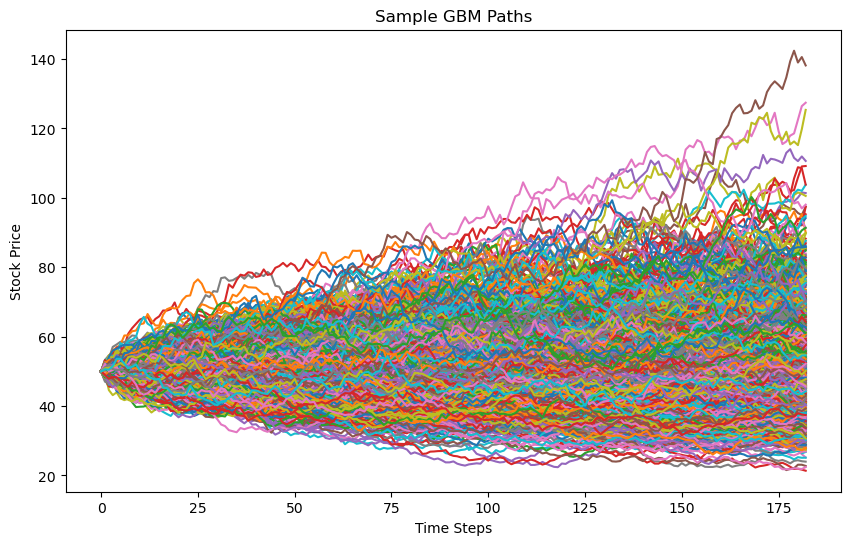

In [9]:
S, X, mu, r, q, sigma = 50, 55, 0.13, 0.04, 0, 0.4
t = 1/2 # 6months
nsim = 1000
shares_per_call = 100_000
flag = 'call'
imvol = 0.46
interval = 1 #일 단위로 헤지

stock_paths = simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call)[9]

plt.figure(figsize=(10, 6))
for i in range(1000):
    plt.plot(stock_paths[i])
plt.title('Sample GBM Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

In [14]:
np.mean(simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call)[8])

66876.83094072019

In [20]:
Mean_without_transcost=np.zeros(1000)
Mean_with_transcost=np.zeros(1000)
for i in tqdm(range(1000)):

    Mean_without_transcost[i]=simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call)[0]
    Mean_with_transcost[i]=simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call)[2]

100%|██████████| 1000/1000 [07:17<00:00,  2.29it/s]


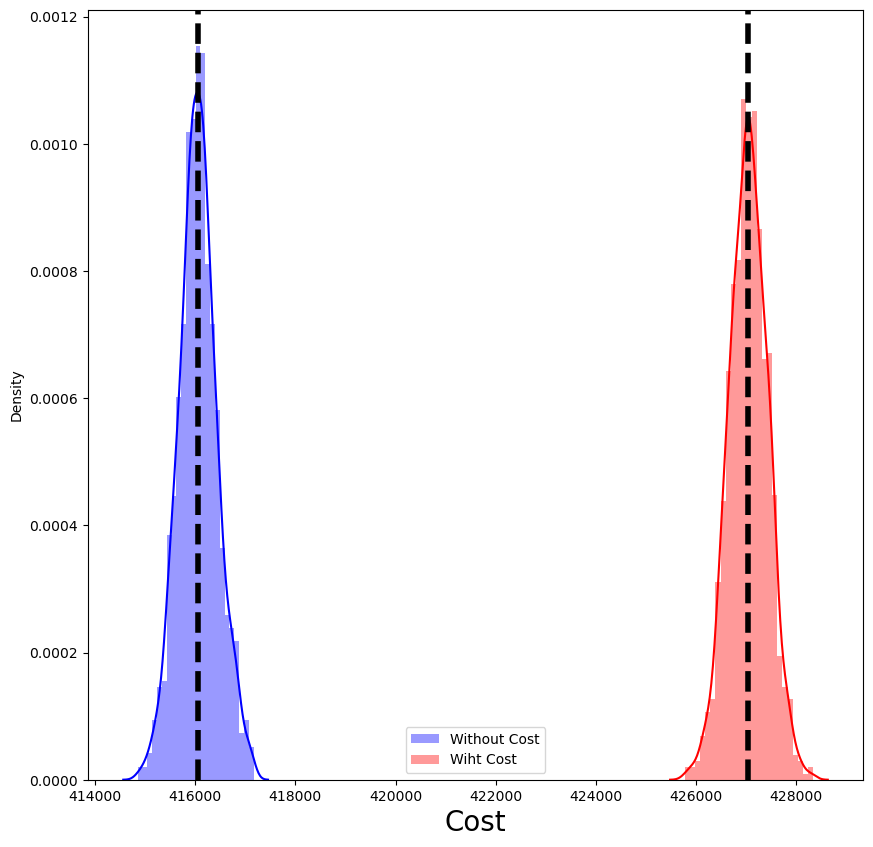

In [21]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.distplot(Mean_without_transcost,color='blue',label='Without Cost')
plt.axvline(x=Mean_without_transcost.mean(),color='black',ls='--',lw=4)

sns.distplot(Mean_with_transcost,color='red',label="Wiht Cost")
plt.axvline(x=Mean_with_transcost.mean(),color='black',ls='--',lw=4)

plt.xlabel("Cost",size=20)
plt.legend()
plt.show()

Mean PNL: 66693.16
Standard Deviation of PNL: 39338.51
Expected_PNL with Continuos Hedging: 84228.02
Performance meaure: 7.97%


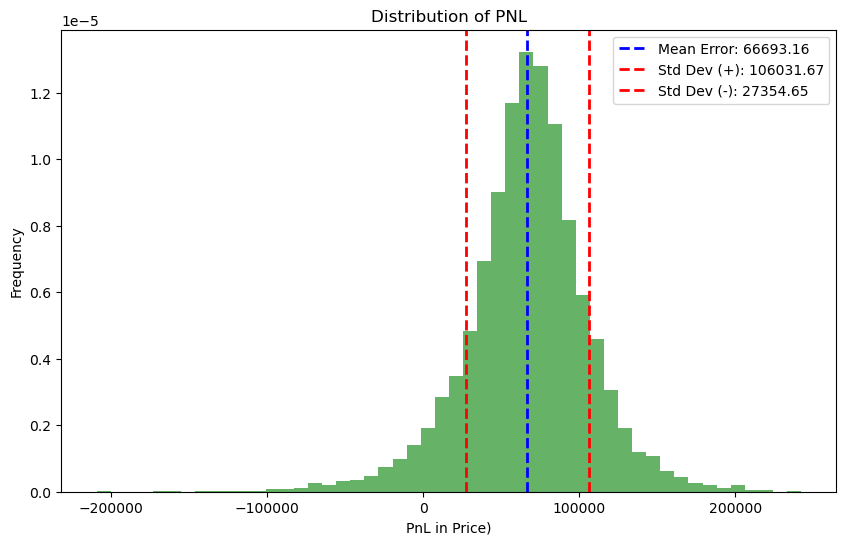

In [30]:
# 파라미터 설정
S, X, mu, r, q, sigma = 50, 55, 0.13, 0.04, 0, 0.4
t = 1 / 2  # 6개월
nsim = 10000
shares_per_call = 100_000
flag = 'call'
imvol = 0.46
interval = 1  # 일 단위로 헤지
call_price = bsprice(S, X, r, q, t, imvol, flag)

# 시뮬레이션 실행
results = simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call)
mean_hedging_cost, performance_msr, mean_hedging_cost_tr, performance_msr_tr, _, _, _, mean_pnl, hedging_pnl, _ , _= results

# 5. Hedging Error 분석
std_error = np.std(hedging_pnl)  # PnL의 표준 편차
mean_error = np.mean(hedging_pnl)  # PnL의 평균

print(f"Mean PNL: {mean_error:.2f}")
print(f"Standard Deviation of PNL: {std_error:.2f}")

# Continuously Hedge 했을때는 15%의 마진을 얻게됨
experceted_PNL = (call_price - bsprice(S, X, r, q, t, imvol=0.4, flag='call'))* shares_per_call
print(f"Expected_PNL with Continuos Hedging: {experceted_PNL:.2f}")

# 6. Relative Hedging Error 계산
option_premium = call_price * shares_per_call  # 옵션 프리미엄
relative_std_error = (std_error / option_premium) * 100  # 상대 표준 편차

print(f"Performance meaure: {relative_std_error:.2f}%")

# PnL 가격 범위를 지정하여 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(hedging_pnl, bins=50, density=True, alpha=0.6, color='g', range=(np.min(hedging_pnl), np.max(hedging_pnl)))
plt.title('Distribution of PNL')
plt.xlabel('PnL in Price)')
plt.ylabel('Frequency')

# 평균과 표준 편차를 표시
plt.axvline(mean_error, color='blue', linestyle='dashed', linewidth=2, label=f'Mean Error: {mean_error:.2f}')
plt.axvline(mean_error + std_error, color='red', linestyle='dashed', linewidth=2, label=f'Std Dev (+): {mean_error + std_error:.2f}')
plt.axvline(mean_error - std_error, color='red', linestyle='dashed', linewidth=2, label=f'Std Dev (-): {mean_error - std_error:.2f}')
plt.legend()
plt.show()

1. PNL의 표준편차가 직관적으로 크다는 것을 알 수 있다. 더 줄일 수 있는 방법은 없을까?
2. PNL의 크기 자체도 더 증가시킬 방법이 없을까?

In [16]:
hedging_pnl

array([ 43152.92599659, 105558.89131258,  61243.94459373, ...,
       114797.7216159 ,  60174.48967979,  47442.80852774])

In [19]:
# 배열 크기와 데이터 타입
print(f"Shape: {hedging_pnl.shape}")
print(f"Data Type: {hedging_pnl.dtype}")

# 통계 요약
print(f"Mean: {np.mean(hedging_pnl):.2f}")
print(f"Standard Deviation: {np.std(hedging_pnl):.2f}")
print(f"Min: {np.min(hedging_pnl):.2f}")
print(f"Max: {np.max(hedging_pnl):.2f}")


Shape: (10000,)
Data Type: float64
Mean: 66280.65
Standard Deviation: 39790.32
Min: -158592.97
Max: 273287.66


### Moneyness에 따른 PNL 비교

1. OTM으로 끝나는경우가 대략 6000번, ITM 4000번, ATM 300번
2. OTM과 ITM Hedge Cost 

PnL Summary for ITM, OTM, ATM Cases:
Category  Mean PNL  Std Hedge Cost  Performance Measure  Hedge Error (%)  Count
     ITM   65164.0         44015.0                0.089           13.206   3976
     OTM   66843.0         36174.0                0.073           13.547   6024
     ATM   98533.0         53350.0                0.108           19.969    286


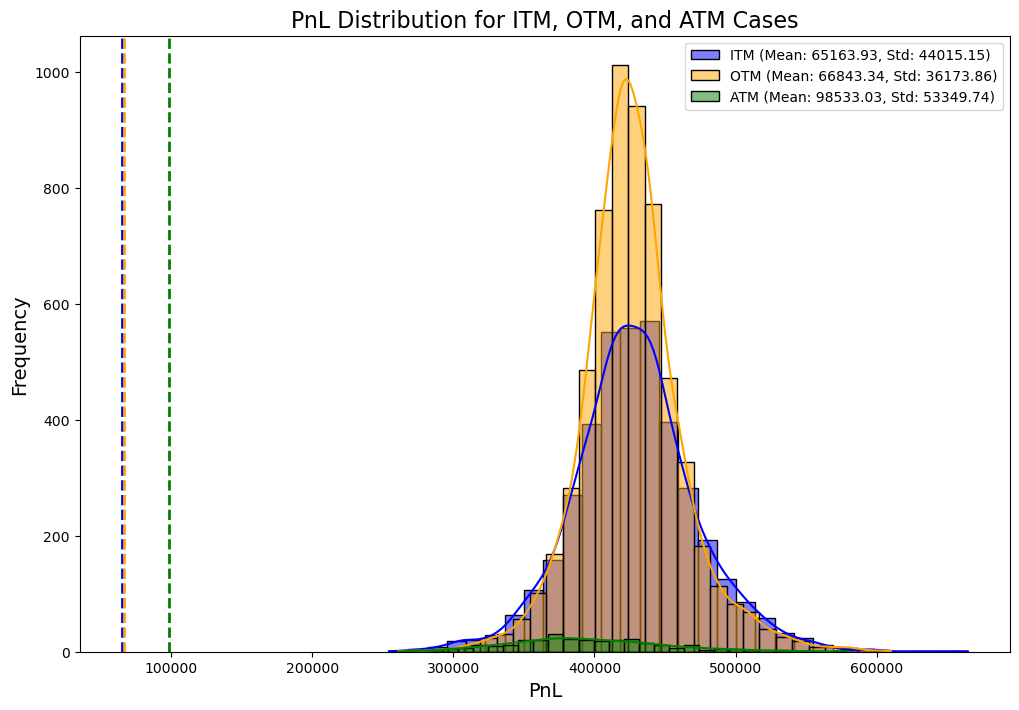

In [90]:
# Simulate or provide itm_case, otm_case, atm_case data from the function
_, _, _, _, itm_case, otm_case, atm_case, _, _, _ , _ = simulate_and_calculate_hedging_cost(S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call)

def plot_combined_pnl_histograms(itm_case, otm_case, atm_case):

    theoretical_price = bsprice(S, X, r, q, t, imvol, flag) * shares_per_call

    itm_mean, itm_std = theoretical_price - np.mean(itm_case), np.std(itm_case)
    otm_mean, otm_std = theoretical_price - np.mean(otm_case), np.std(otm_case)
    atm_mean, atm_std = theoretical_price - np.mean(atm_case), np.std(atm_case)
    
    itm_perm = round(np.std(itm_case - theoretical_price) / theoretical_price,3)
    itm_error = round(np.abs((np.mean(itm_case) - theoretical_price))/theoretical_price *100,3)    

    otm_perm = round(np.std(otm_case - theoretical_price) / theoretical_price,3)
    otm_error = round(np.abs((np.mean(otm_case) - theoretical_price))/theoretical_price *100,3)
    
    atm_perm = round(np.std(atm_case - theoretical_price) / theoretical_price,3)
    atm_error = round(np.abs((np.mean(atm_case) - theoretical_price))/theoretical_price *100,3)

    itm_count = len(itm_case)
    otm_count = len(otm_case)
    atm_count = len(atm_case)

    summary_df = pd.DataFrame({
        "Category": ["ITM", "OTM", "ATM"],
        "Mean PNL": [round(itm_mean, 0), round(otm_mean, 0), round(atm_mean, 0)],
        "Std Hedge Cost": [round(itm_std, 0), round(otm_std, 0), round(atm_std, 0)],
        "Performance Measure": [itm_perm, otm_perm, atm_perm],
        "Hedge Error (%)": [itm_error, otm_error, atm_error],
        "Count": [itm_count, otm_count, atm_count]
    })

    print("PnL Summary for ITM, OTM, ATM Cases:")
    print(summary_df.to_string(index=False))

    plt.figure(figsize=(12, 8))

    # ITM
    sns.histplot(itm_case, bins=30, color='blue', label=f'ITM (Mean: {itm_mean:.2f}, Std: {itm_std:.2f})', kde=True)
    plt.axvline(x=itm_mean, color='blue', ls='--', lw=2)

    # OTM
    sns.histplot(otm_case, bins=30, color='orange', label=f'OTM (Mean: {otm_mean:.2f}, Std: {otm_std:.2f})', kde=True)
    plt.axvline(x=otm_mean, color='orange', ls='--', lw=2)

    # ATM
    sns.histplot(atm_case, bins=30, color='green', label=f'ATM (Mean: {atm_mean:.2f}, Std: {atm_std:.2f})', kde=True)
    plt.axvline(x=atm_mean, color='green', ls='--', lw=2)

    plt.title("PnL Distribution for ITM, OTM, and ATM Cases", size=16)
    plt.xlabel("PnL", size=14)
    plt.ylabel("Frequency", size=14)
    plt.legend()
    plt.show()

plot_combined_pnl_histograms(itm_case, otm_case, atm_case)


1. OTM이 헤징 성과가 더 좋은 것 같지만, OTM 옵션은 델타 값이 작아 작은 주가 변동에는 크게 영향을 받지않아서 표준편차가 낮게 나오는 경향임.
2. 하지만, 시장이 급격하게 움직이는 경우 헤징 성과가 갑작스럽게 나빠질 가능성 있음

해결책:
1. Adaptive Rebalancing 전략
델타의 변화에 대해 특정 Treshhold를 초과하면 리밸런싱 수행
 1) 주가의 급격한 변화에 리밸런싱 수행 
 2)  이외에는 리밸런싱 주기를 늘려서 거래비용 줄임
 3) But 변동성이 고정된 상태에서 의미가 있나 싶음...
2. Dynamic Delta Trigger
 1) 델타가 특정 구간에 있을때만 리밸런싱, 0과 1에 가까울 떄는 추가 조정을 하지않음

In [ ]:

# def simulate_and_calculate_hedging_cost_with_trigger_and_vol(
#     S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call, 
#     delta_threshold=0.05, vol_threshold=0.35):
#     dt = interval / 365  # Rebalancing interval in years
#     m = int(t / dt) + 1  # Number of rebalancing steps

#     # Monte Carlo simulation of stock paths
#     z = np.random.randn(nsim, m - 1)
#     schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
#     stock_paths = np.zeros((nsim, m))
#     stock_paths[:, 0] = S
#     stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)

#     # Time to maturity
#     time_to_maturity = t - np.arange(m) * dt
#     time_to_maturity = np.maximum(0, time_to_maturity)

#     # Delta calculation
#     deltas = delta(stock_paths[:, :-1], X, r, q, time_to_maturity[:-1], sigma, flag)
#     deltas = np.hstack((deltas, np.where(stock_paths[:, -1:] >= X, 1.0, 0.0)))

#     # Delta difference
#     delta_diff = deltas[:, 1:] - deltas[:, :-1]
#     delta_diff_trigger = np.where(np.abs(delta_diff) > np.abs(deltas[:, :-1]) * delta_threshold, delta_diff, 0)

#     # Re-apply initial delta for the first rebalancing step
#     initial_array = np.repeat(deltas[:, 0].reshape(-1, 1), 1, axis=1)
#     delta_change = np.concatenate([initial_array, delta_diff_trigger], axis=1)

#     # Volatility threshold: apply rebalancing if sigma exceeds vol_threshold
#     rebalance_mask = (np.abs(delta_diff) > np.abs(deltas[:, :-1]) * delta_threshold)
#     delta_change = np.where(rebalance_mask, delta_diff, 0)

#     # Shares purchased based on delta change
#     shares_purchased = delta_change * shares_per_call
#     cost_of_shares = shares_purchased * stock_paths[:, :-1]
#     transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

#     # Cumulative costs
#     cumulative_costs = np.cumsum(cost_of_shares, axis=1)
#     interest_costs = np.zeros_like(cumulative_costs)
#     interest_costs[:, :-1] = cumulative_costs[:, :-1] * (np.exp(r * dt) - 1)
#     cumulative_costs[:, 1:] += np.cumsum(interest_costs[:, :-1], axis=1)

#     # Final costs
#     final_cost = cumulative_costs[:, -1]
#     hedge_cost = np.where(stock_paths[:, -1] > X, final_cost - X * shares_per_call, final_cost)
#     hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)    # 최종 비용 계산

#     # Calculate Performance Measure
#     # Moneyness 비교
#     final_prices = stock_paths[:, -1]
#     atm_case = hedge_cost_with_transaction[(final_prices < 1.01 * X) & (final_prices > 0.99 * X)]
#     itm_case = hedge_cost_with_transaction[final_prices > X]
#     otm_case = hedge_cost_with_transaction[final_prices < X]

#     # PnL 계산
#     call_price = bsprice(S, X, r, q, t, imvol, flag)
#     hedging_pnl = call_price * shares_per_call - hedge_cost_with_transaction

#     # 통계 계산
#     mean_hedging_cost = np.mean(hedge_cost)
#     performance_msr = np.std(hedge_cost - call_price) / call_price 
#     mean_hedging_cost_tr = np.mean(hedge_cost_with_transaction)
#     performance_msr_tr = np.std(hedge_cost_with_transaction) / call_price 
#     mean_pnl = np.mean(hedging_pnl)

#     df_results = pd.DataFrame({
#         "Stock Price": final_prices,
#         "Hedge Cost": hedge_cost,
#         "Hedge Cost with Transaction": hedge_cost_with_transaction,
#         "PnL": hedging_pnl
#     })

#     return (
#         mean_hedging_cost,
#         performance_msr,
#         mean_hedging_cost_tr,
#         performance_msr_tr,
#         itm_case,
#         otm_case,
#         atm_case,
#         mean_pnl,
#         hedging_pnl,
#         stock_paths,
#         df_results
#     )


In [68]:
def simulate_and_calculate_hedging_cost_with_trigger_and_vol(
    S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call, 
    delta_threshold=0.05, vol_threshold=0.35):
    dt = interval / 365  # Rebalancing interval in years
    m = int(t / dt) + 1  # Number of rebalancing steps

    # Monte Carlo simulation of stock paths
    z = np.random.randn(nsim, m - 1)
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    stock_paths = np.zeros((nsim, m))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)

    # Time to maturity
    time_to_maturity = t - np.arange(m) * dt
    time_to_maturity = np.maximum(0, time_to_maturity)

    # Delta calculation
    deltas = delta(stock_paths[:, :-1], X, r, q, time_to_maturity[:-1], sigma, flag)
    deltas = np.hstack((deltas, np.where(stock_paths[:, -1:] >= X, 1.0, 0.0)))

    # Delta difference
    delta_diff = deltas[:, 1:] - deltas[:, :-1]
    delta_diff_trigger = np.where(np.abs(delta_diff) > np.abs(deltas[:, :-1]) * delta_threshold, delta_diff, 0)

    # Re-apply initial delta for the first rebalancing step
    initial_array = np.repeat(deltas[:, 0].reshape(-1, 1), 1, axis=1)
    delta_change = np.concatenate([initial_array, delta_diff_trigger], axis=1)

    # Adjust dimensions to match stock paths
    delta_change = delta_change[:, :-1]  # Ensure same shape as `stock_paths[:, :-1]`

    # Shares purchased based on delta change
    shares_purchased = delta_change * shares_per_call
    cost_of_shares = shares_purchased * stock_paths[:, :-1]
    transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

    # Cumulative costs
    cumulative_costs = np.cumsum(cost_of_shares, axis=1)
    interest_costs = np.zeros_like(cumulative_costs)
    interest_costs[:, :-1] = cumulative_costs[:, :-1] * (np.exp(r * dt) - 1)
    cumulative_costs[:, 1:] += np.cumsum(interest_costs[:, :-1], axis=1)

    # Final costs
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(stock_paths[:, -1] > X, final_cost - X * shares_per_call, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)

    # Moneyness 비교
    final_prices = stock_paths[:, -1]
    atm_case = hedge_cost_with_transaction[(final_prices < 1.01 * X) & (final_prices > 0.99 * X)]
    itm_case = hedge_cost_with_transaction[final_prices > X]
    otm_case = hedge_cost_with_transaction[final_prices < X]
    
    # PnL 계산
    call_price = bsprice(S, X, r, q, t, imvol, flag)
    hedging_pnl = call_price * shares_per_call - hedge_cost_with_transaction

    # 통계 계산
    mean_hedging_cost = np.mean(hedge_cost)
    performance_msr = np.std(hedge_cost - call_price) / call_price 
    mean_hedging_cost_tr = np.mean(hedge_cost_with_transaction)
    performance_msr_tr = np.std(hedge_cost_with_transaction - call_price) / call_price 
    mean_pnl = np.mean(hedging_pnl)

    df_results = pd.DataFrame({
        "Stock Price": final_prices,
        "Hedge Cost": hedge_cost,
        "Hedge Cost with Transaction": hedge_cost_with_transaction,
        "PnL": hedging_pnl
    })

    return (
        mean_hedging_cost,
        performance_msr,
        mean_hedging_cost_tr,
        performance_msr_tr,
        itm_case,
        otm_case,
        atm_case,
        mean_pnl,
        hedging_pnl,
        stock_paths,
        df_results
    )


In [69]:
S, X, mu, r, q, sigma = 50, 55, 0.13, 0.04, 0, 0.4
t = 1 / 2  # 6 months
nsim = 10000
shares_per_call = 100_000
flag = 'call'
imvol = 0.46
interval = 1  # daily hedging
vol_threshold = 0.3

# Delta thresholds to test
delta_thresholds = np.linspace(0.05, 0.3, 20)

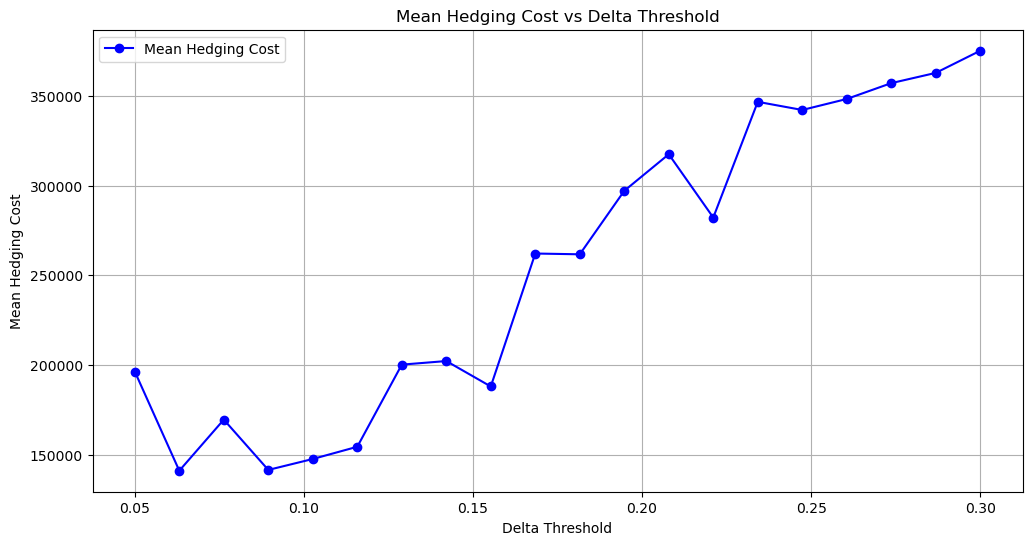

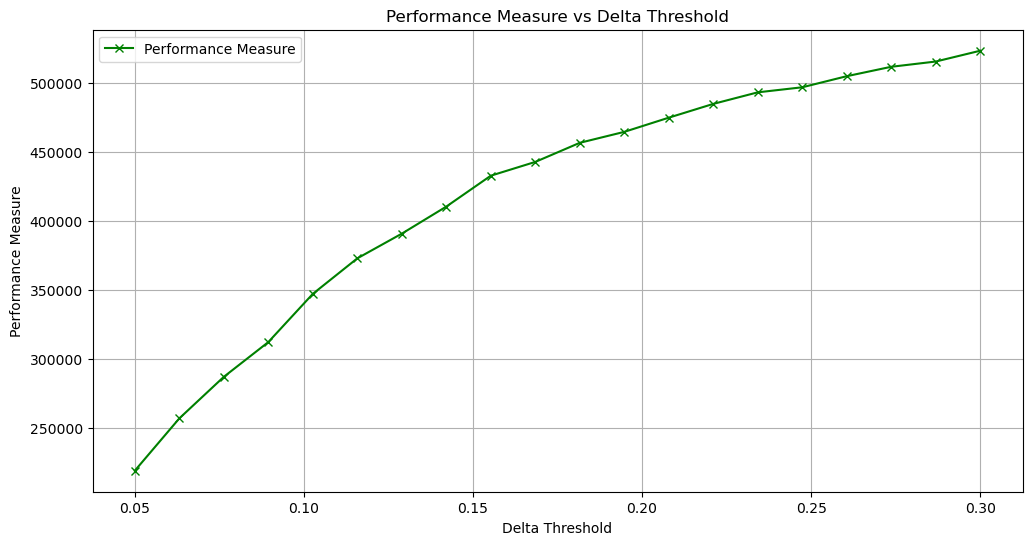

In [70]:
results = [
    simulate_and_calculate_hedging_cost_with_trigger_and_vol(
        S, X, r, mu, q, sigma, t, nsim, interval, flag, shares_per_call, 
        delta_threshold=threshold, vol_threshold=vol_threshold
    )
    for threshold in delta_thresholds
]

_, _, mean_hedging_cost_trigger, performance_msr_trigger, _, _, _, _, _, _ , _ = zip(*results)

# Plot Mean Hedging Cost and Performance Measure in separate graphs

# Plot Mean Hedging Cost
plt.figure(figsize=(12, 6))
plt.plot(delta_thresholds, mean_hedging_cost_trigger, marker='o', label='Mean Hedging Cost', color='blue')
plt.title("Mean Hedging Cost vs Delta Threshold")
plt.xlabel("Delta Threshold")
plt.ylabel("Mean Hedging Cost")
plt.grid()
plt.legend()
plt.show()

# Plot Performance Measure
plt.figure(figsize=(12, 6))
plt.plot(delta_thresholds, performance_msr_trigger, marker='x', label='Performance Measure', color='green')
plt.title("Performance Measure vs Delta Threshold")
plt.xlabel("Delta Threshold")
plt.ylabel("Performance Measure")
plt.grid()
plt.legend()
plt.show()


### 결과분석

1. Delta Threshhold가 작을수록 (기준이 덜 보수적일수록) 헷징코스트가 낮음
1) 이유: 더 자주 리밸런싱하기 때문
2) 특정점 이상부터는 영향 X (주가의 큰 움직임을 적절히 커버 못함)
2. Delta Threshhold가 작을수록, 퍼포먼스 측정치가 낮아짐
1) 같은 이유로 더 자주 리밸런싱하기 때문

With Trigger and Volatility Threshold:
Mean PnL: 135696.93
Standard Deviation of PnL: 2103089.36
Performance Measure (Relative Hedging Error): 91.44%

BSM (Standard Delta Hedging):
Mean PnL: 66550.63
Standard Deviation of PnL: 39111.19
Performance Measure (Relative Hedging Error): 1.70%


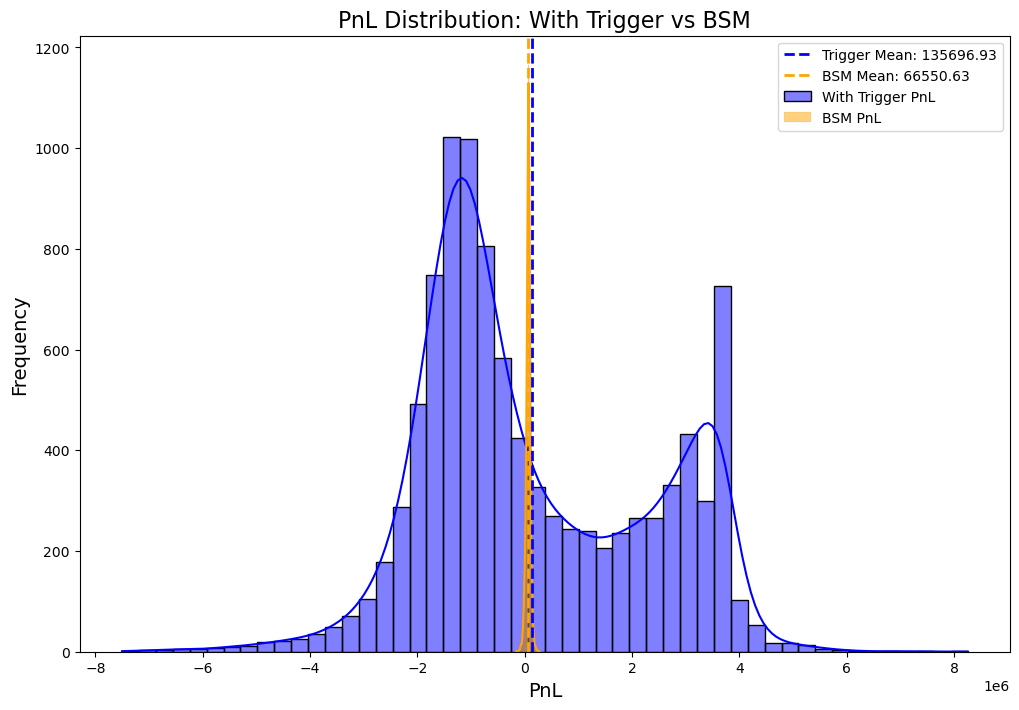

In [67]:
import seaborn as sns

# 설정된 파라미터
S, X, mu, r, q, sigma = 50, 55, 0.13, 0.04, 0, 0.4
T = 0.5  # 6 months
nsim = 10000
shares_per_call = 100_000
flag = 'call'
imvol = 0.46
interval = 1  # 일 단위 리밸런싱
delta_threshold = 0.15
vol_threshold = 0.35

# 헷징 계산
results_with_trigger = simulate_and_calculate_hedging_cost_with_trigger_and_vol(
    S, X, r, mu, q, sigma, T, nsim, interval, flag, shares_per_call, 
    delta_threshold, vol_threshold
)

results_bsm = simulate_and_calculate_hedging_cost(
    S, X, r, mu, q, sigma, T, nsim, interval, flag, shares_per_call
)

# 결과 비교
mean_pnl_with_trigger = results_with_trigger[7]
std_pnl_with_trigger = np.std(results_with_trigger[8])
relative_error_with_trigger = std_pnl_with_trigger / (imvol * S * shares_per_call) * 100

mean_pnl_bsm = results_bsm[7]
std_pnl_bsm = np.std(results_bsm[8])
relative_error_bsm = std_pnl_bsm / (imvol * S * shares_per_call) * 100

# 출력
print("With Trigger and Volatility Threshold:")
print(f"Mean PnL: {mean_pnl_with_trigger:.2f}")
print(f"Standard Deviation of PnL: {std_pnl_with_trigger:.2f}")
print(f"Performance Measure (Relative Hedging Error): {relative_error_with_trigger:.2f}%\n")

print("BSM (Standard Delta Hedging):")
print(f"Mean PnL: {mean_pnl_bsm:.2f}")
print(f"Standard Deviation of PnL: {std_pnl_bsm:.2f}")
print(f"Performance Measure (Relative Hedging Error): {relative_error_bsm:.2f}%")

# PnL 히스토그램 비교
plt.figure(figsize=(12, 8))
sns.histplot(results_with_trigger[8], bins=50, color='blue', alpha=0.5, label='With Trigger PnL', kde=True)
sns.histplot(results_bsm[8], bins=50, color='orange', alpha=0.5, label='BSM PnL', kde=True)

plt.title("PnL Distribution: With Trigger vs BSM", size=16)
plt.xlabel("PnL", size=14)
plt.ylabel("Frequency", size=14)
plt.axvline(mean_pnl_with_trigger, color='blue', linestyle='dashed', linewidth=2, label=f'Trigger Mean: {mean_pnl_with_trigger:.2f}')
plt.axvline(mean_pnl_bsm, color='orange', linestyle='dashed', linewidth=2, label=f'BSM Mean: {mean_pnl_bsm:.2f}')
plt.legend()
plt.show()


----------------------------------------------------------------------------------

### 실현변동성이 Given 40%가 아니라면? 

1. Heston 모델의 주가 경로와 변동성 경로 생성
2. Heston 모델에서 델타는 주가 뿐만 아니라 변동성의 영향을 받음 (변동성을 동적으로 반영한 델타 계산)
3. Heston 모델은 특히 ATM 옵션의 높은 감마(Gamma)로 인한 성과 불안정을 개선할 가능성이 큼
4. 필요 이상의 헷징 거래를 줄이는 효과
5. PnL 변동성 감소와 함께 헷징 비용 절감이 가능
6. 변동성 군집과 평균회귀, 주가와 변동성 간의 상관관계, Vol Skew, Fat tail 반영

Stochastic Vol path 및 Heston Model을 이용한 헷지

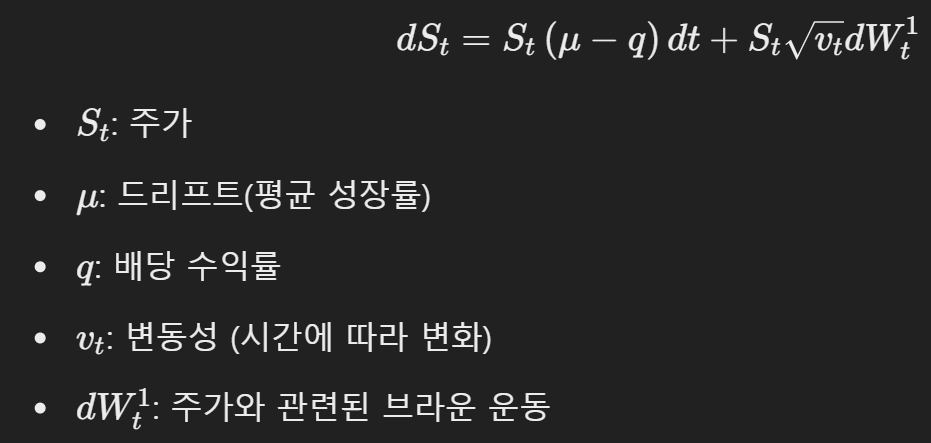
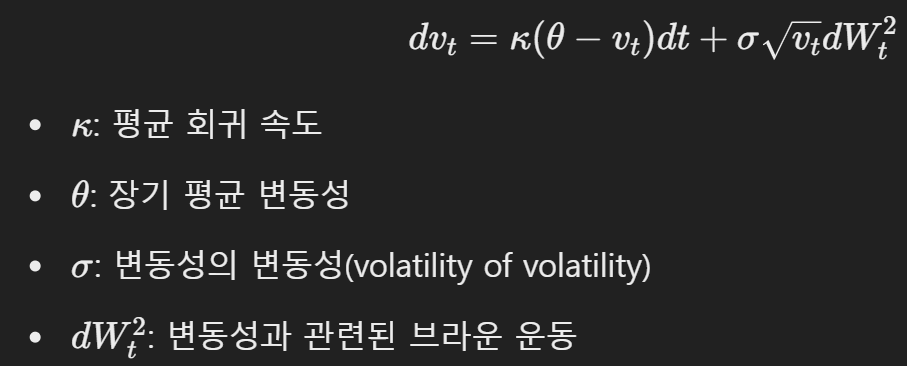
![image-3.png](attachment:image-3.png)

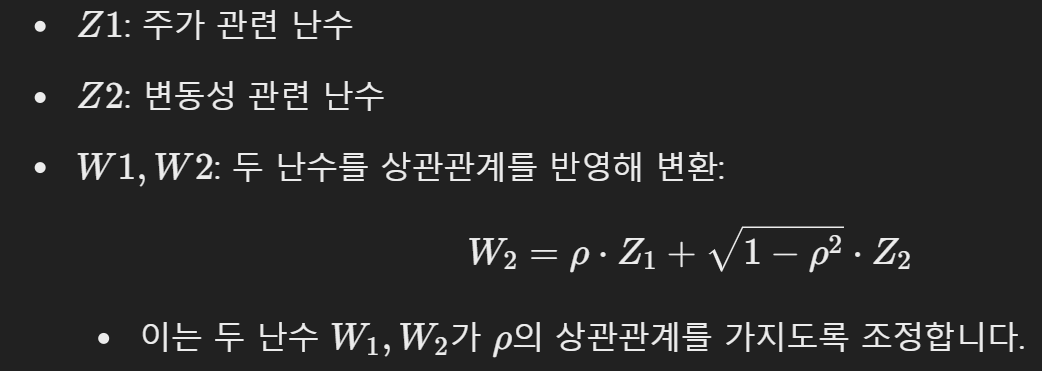

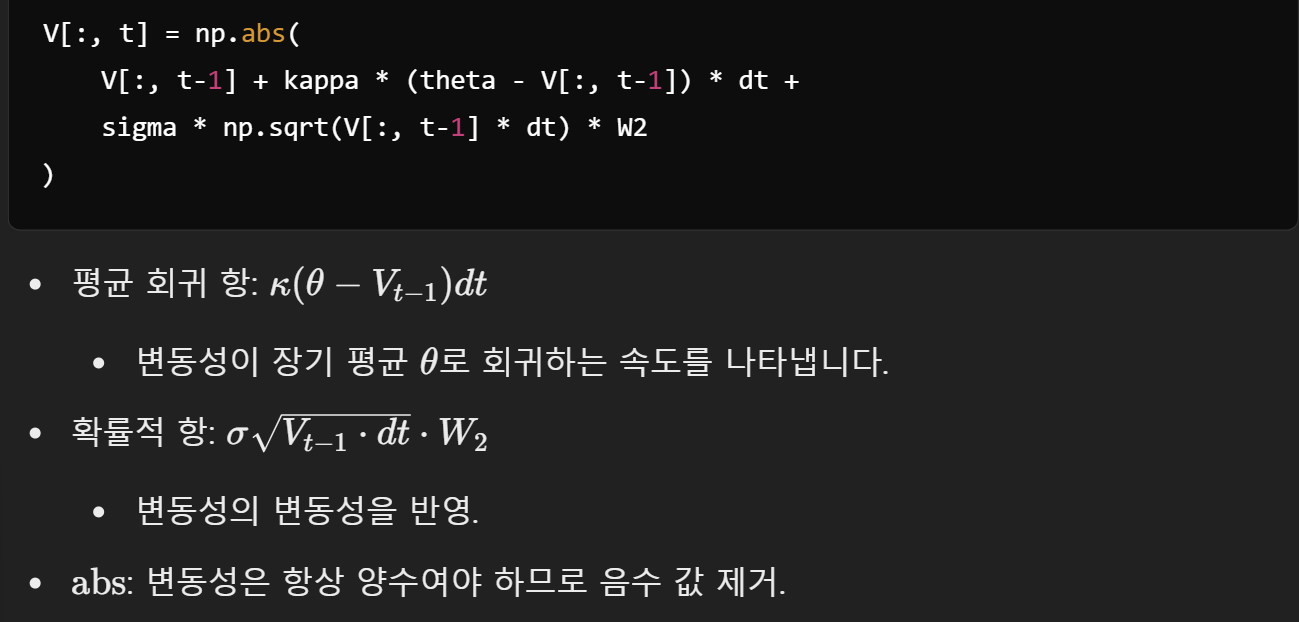
절대값을 씌우는 과정에서 오류가 발생

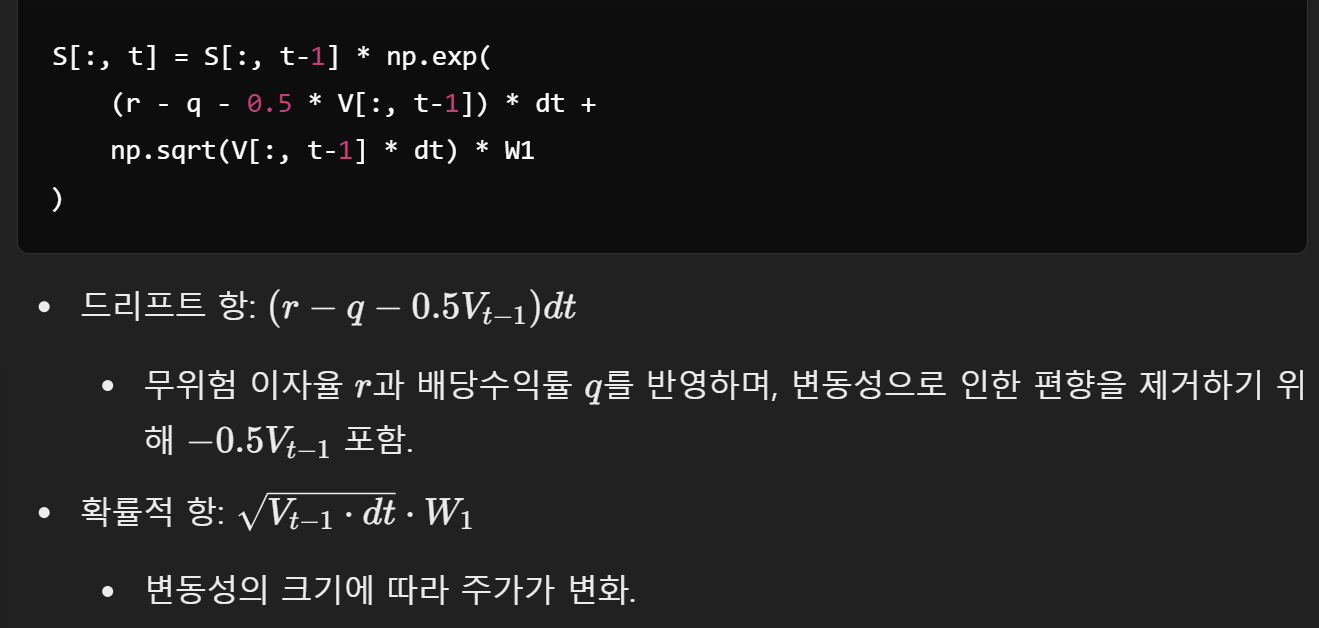

![image.png](attachment:image.png)

In [110]:
from scipy.stats import norm

# Heston 모델을 통한 주가 및 변동성 경로 시뮬레이션
def simulate_heston_paths(S0, v0, r, q, T, dt, kappa, theta, sigma, rho, nsim):
    """
    Heston 모델을 기반으로 주가 및 변동성 경로 시뮬레이션.
    """
    nsteps = int(T / dt)
    S = np.zeros((nsim, nsteps + 1))
    V = np.zeros((nsim, nsteps + 1))
    S[:, 0] = S0
    V[:, 0] = v0

    for t in range(1, nsteps + 1):
        Z1 = np.random.normal(size=nsim)
        Z2 = np.random.normal(size=nsim)
        W1 = Z1
        W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2

        V[:, t] = np.abs(
            V[:, t-1] + kappa * (theta - V[:, t-1]) * dt +
            sigma * np.sqrt(V[:, t-1] * dt) * W2
        )
        S[:, t] = S[:, t-1] * np.exp(
            (r - q - 0.5 * V[:, t-1]) * dt +
            np.sqrt(V[:, t-1] * dt) * W1
        )

    return S, V

# Heston 델타 계산
def heston_delta(S, X, r, q, t, sigma_path, flag):
    """
    동적 변동성을 기반으로 Heston 델타 계산.
    """
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma_path**2) * t) / (sigma_path * np.sqrt(t))
    return norm.cdf(d1) if flag.lower() == 'call' else norm.cdf(d1) - 1

# Heston 기반 헤징 성과 분석 함수
def simulate_and_calculate_hedging_cost_heston(S, X, r, q, kappa, theta, sigma, rho, T, nsim, interval, flag, shares_per_call):
    dt = interval / 365  # 리밸런싱 간격 (연 단위)
    m = int(T / dt) + 1  # 리밸런싱 스텝 수

    # Heston 모델로 주가 및 변동성 경로 생성
    S_paths, V_paths = simulate_heston_paths(S, 0.04, r, q, T, dt, kappa, theta, sigma, rho, nsim)

    # 잔여 시간 계산
    time_to_maturity = T - np.arange(m) * dt
    time_to_maturity = np.maximum(0, time_to_maturity)  # 음수 방지

    # 델타 계산 (전체 경로에서 동적 변동성 적용)
    deltas = heston_delta(S_paths[:, :-1], X, r, q, time_to_maturity[:-1], np.sqrt(V_paths[:, :-1]), flag)
    deltas = np.hstack((deltas, np.where(S_paths[:, -1:] >= X, 1.0, 0.0)))

    # Delta 차이 계산 및 주식 매수/매도
    delta_diff = np.diff(np.hstack((np.zeros((nsim, 1)), deltas)), axis=1)
    shares_purchased = delta_diff * shares_per_call

    # 매수/매도 비용 계산
    cost_of_shares = shares_purchased * S_paths

    # 거래 비용 계산
    transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

    # 누적 비용 계산
    cumulative_costs = np.cumsum(cost_of_shares, axis=1)
    interest_costs = np.zeros_like(cumulative_costs)
    interest_costs[:, :-1] = cumulative_costs[:, :-1] * (np.exp(r * dt) - 1)
    cumulative_costs[:, 1:] += np.cumsum(interest_costs[:, :-1], axis=1)

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(S_paths[:, -1] > X, final_cost - X * shares_per_call, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)

    # Moneyness 비교 (ITM, ATM, OTM)
    atm_case = hedge_cost_with_transaction[(S_paths[:, -1] < 1.01 * X) & (S_paths[:, -1] > 0.99 * X)]
    itm_case = hedge_cost_with_transaction[S_paths[:, -1] > X]
    otm_case = hedge_cost_with_transaction[S_paths[:, -1] < X]

    # PnL 계산
    theoretical_price = bsprice(S, X, r, q, T, imvol, flag)
    hedging_pnl = theoretical_price * shares_per_call - hedge_cost_with_transaction

    # 통계 계산
    mean_hedging_cost = np.mean(hedge_cost)
    performance_msr = np.std(hedge_cost - theoretical_price) / np.mean(theoretical_price)
    mean_hedging_cost_tr = np.mean(hedge_cost_with_transaction)
    performance_msr_tr = np.std(hedge_cost_with_transaction) / np.mean(theoretical_price)
    mean_pnl = np.mean(hedging_pnl)

    df_results = pd.DataFrame({
        "Stock Price": S_paths[:, -1],
        "Hedge Cost": hedge_cost,
        "Hedge Cost with Transaction": hedge_cost_with_transaction,
        "PnL": hedging_pnl,
    })

    return (
        mean_hedging_cost,
        performance_msr,
        mean_hedging_cost_tr,
        performance_msr_tr,
        itm_case,
        otm_case,
        atm_case,
        mean_pnl,
        hedging_pnl,
        S_paths,
        df_results
    )


보통 Heston 모델의 파라미터는 캘리브레이션을 통해 얻지만, 우선 S&P 500의 파라미터와 우리가 가정한 장기변동성 40%를 이용하기로 가정함

In [ ]:
# Parameters
S = 50
X = 55
r = 0.04
q = 0
imvol = 0.46
T = 0.5  # 6개월
# S&P 500 옵션 파라미터 "Adaptive calibration of Heston Model using PCRLB based switching Filter (2021)""
kappa = 2.0 # 변동성 평균 회귀 속도
theta = 0.16 # 해당 논문에서는 0.01 이지만, 40% 변동성을 가정하기 위해 장기 변동성의 루트인 theta를 0.16으로 설정정
sigma = 0.2 # 변동성의 변동성
rho = -0.5 # 주가와 변동성 간의 상관관계
nsim = 1000
interval = 1  # 하루 단위 리밸런싱
flag = "call"
shares_per_call = 100_000


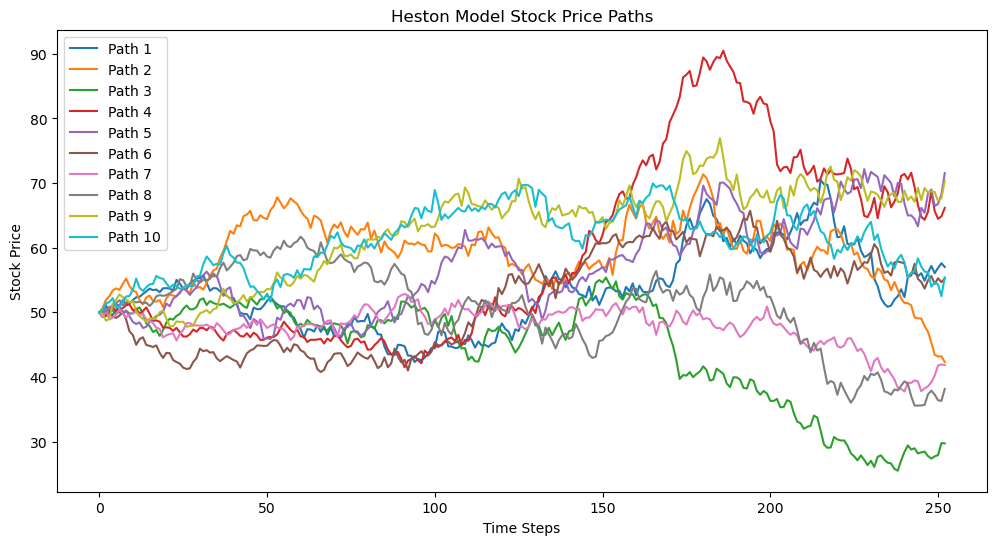

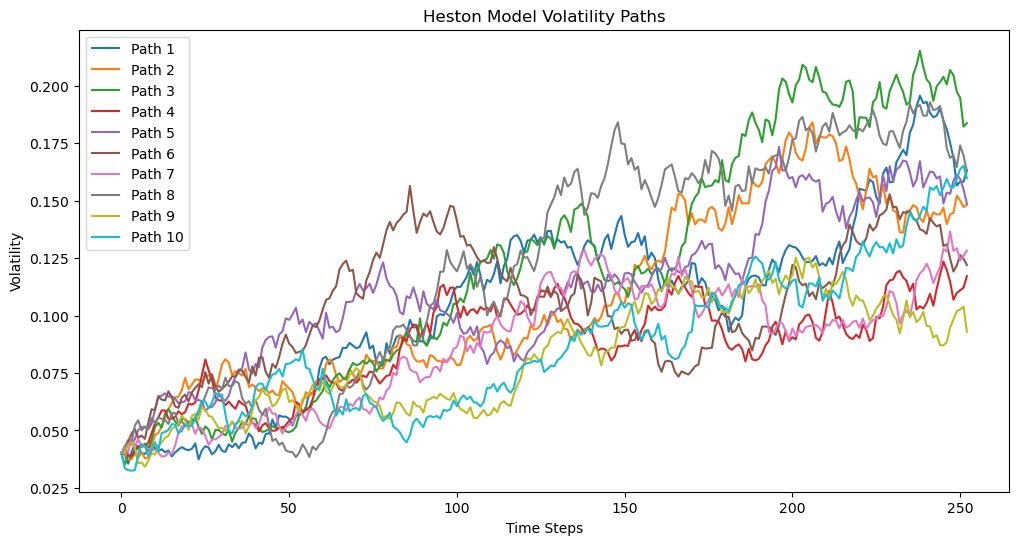

In [122]:
# Heston 시뮬레이션 실행
S_paths, V_paths = simulate_heston_paths(S0=50, v0=0.04, r=0.04, q=0, T=1, dt=1/252, kappa=2.0, theta=0.16, sigma=0.2, rho=-0.5, nsim=10)

# 주가 경로 시각화
plt.figure(figsize=(12, 6))
for i in range(10):  # 10개의 경로만 그리기
    plt.plot(S_paths[i], label=f'Path {i+1}')
plt.title('Heston Model Stock Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 변동성 경로 시각화
plt.figure(figsize=(12, 6))
for i in range(10):  # 10개의 경로만 그리기
    plt.plot(V_paths[i], label=f'Path {i+1}')
plt.title('Heston Model Volatility Paths')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.show()


Stochastic Vol Path에서의 변동성 40%를 가정한 BSM 모델 기반 헷지

In [117]:
def simulate_and_calculate_hedging_cost_gbm(S, X, r, q, sigma, T, nsim, interval, flag, shares_per_call, S_paths):
    """
    GBM(40% 변동성) 기반으로 주어진 주가 경로에서 헷징 성과를 계산.
    """
    dt = interval / 365  # 리밸런싱 간격 (연 단위)
    m = int(T / dt) + 1  # 리밸런싱 스텝 수

    # 잔여 시간 계산
    time_to_maturity = T - np.arange(m) * dt
    time_to_maturity = np.maximum(0, time_to_maturity)  # 음수 방지

    # GBM 기준 델타 계산
    deltas = delta(S_paths[:, :-1], X, r, q, time_to_maturity[:-1], sigma, flag)
    deltas = np.hstack((deltas, np.where(S_paths[:, -1:] >= X, 1.0, 0.0)))

    # Delta 차이 계산 및 주식 매수/매도
    delta_diff = np.diff(np.hstack((np.zeros((nsim, 1)), deltas)), axis=1)
    shares_purchased = delta_diff * shares_per_call

    # 매수/매도 비용 계산
    cost_of_shares = shares_purchased * S_paths

    # 거래 비용 계산
    transaction_costs = np.where(cost_of_shares < 0, np.abs(cost_of_shares) * 0.001, 0)

    # 누적 비용 계산
    cumulative_costs = np.cumsum(cost_of_shares, axis=1)
    interest_costs = np.zeros_like(cumulative_costs)
    interest_costs[:, :-1] = cumulative_costs[:, :-1] * (np.exp(r * dt) - 1)
    cumulative_costs[:, 1:] += np.cumsum(interest_costs[:, :-1], axis=1)

    # 최종 비용 계산
    final_cost = cumulative_costs[:, -1]
    hedge_cost = np.where(S_paths[:, -1] > X, final_cost - X * shares_per_call, final_cost)
    hedge_cost_with_transaction = hedge_cost + np.sum(transaction_costs, axis=1)

    # Moneyness 비교 (ITM, ATM, OTM)
    atm_case = hedge_cost_with_transaction[(S_paths[:, -1] < 1.01 * X) & (S_paths[:, -1] > 0.99 * X)]
    itm_case = hedge_cost_with_transaction[S_paths[:, -1] > X]
    otm_case = hedge_cost_with_transaction[S_paths[:, -1] < X]

    # PnL 계산
    theoretical_price = bsprice(S, X, r, q, T, sigma, flag)
    hedging_pnl = theoretical_price * shares_per_call - hedge_cost_with_transaction

    # 통계 계산
    mean_hedging_cost = np.mean(hedge_cost)
    performance_msr = np.std(hedge_cost - theoretical_price) / np.mean(theoretical_price)
    mean_hedging_cost_tr = np.mean(hedge_cost_with_transaction)
    performance_msr_tr = np.std(hedge_cost_with_transaction) / np.mean(theoretical_price)
    mean_pnl = np.mean(hedging_pnl)

    return {
        "mean_hedging_cost": mean_hedging_cost,
        "performance_msr": performance_msr,
        "mean_hedging_cost_tr": mean_hedging_cost_tr,
        "performance_msr_tr": performance_msr_tr,
        "mean_pnl": mean_pnl,
        "std_pnl": np.std(hedging_pnl),
        "relative_error": (np.std(hedging_pnl) / (theoretical_price * shares_per_call)) * 100,
        "atm_case": atm_case,
        "itm_case": itm_case,
        "otm_case": otm_case,
        "hedging_pnl": hedging_pnl
    }


In [111]:
heston_df = simulate_and_calculate_hedging_cost_heston(S, X, r, q, kappa, theta, sigma, rho, T, nsim, interval, flag, shares_per_call)[-1]
heston_df

,Stock Price,Hedge Cost,Hedge Cost with Transaction,PnL
0,47.342154,290882.776391,299978.464327,193451.297574
1,47.370547,367186.687560,383466.938758,109962.823143
2,39.752982,320906.788595,333409.669772,160020.092129
3,26.688879,259219.028468,265194.740508,228235.021393
4,54.380023,243916.884709,261822.797573,231606.964328
...,...,...,...,...
995,55.007866,183272.701290,194814.903932,298614.857969
996,46.559760,275242.840276,283606.004842,209823.757059
997,32.691722,240623.026992,245728.995779,247700.766121
998,49.838323,255492.021894,264216.671862,229213.090039


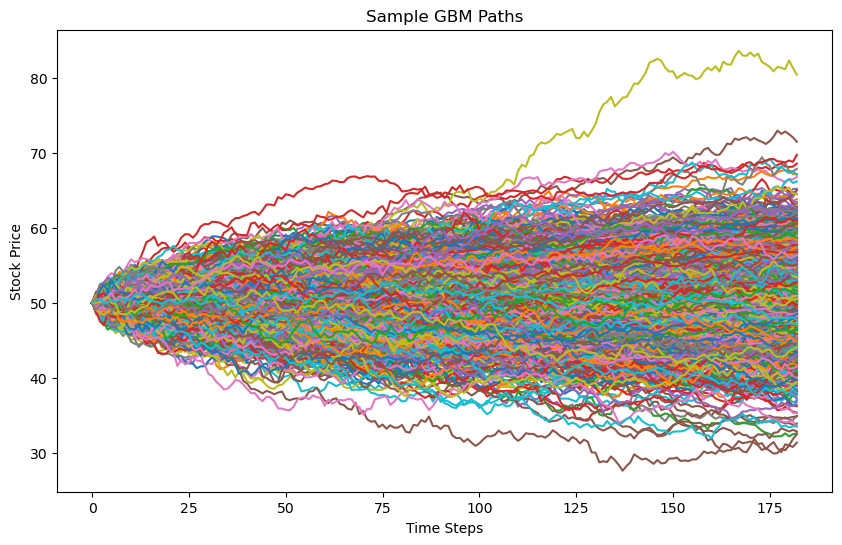

In [104]:
stock_paths = simulate_and_calculate_hedging_cost_heston(S, X, r, q, kappa, theta, sigma, rho, T, nsim, interval, flag, shares_per_call)[9]

plt.figure(figsize=(10, 6))
for i in range(1000):
    plt.plot(stock_paths[i])
plt.title('Sample GBM Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

Mean PNL: 230394.87
Standard Deviation of PNL: 47837.89
Performance meaure: 9.69%


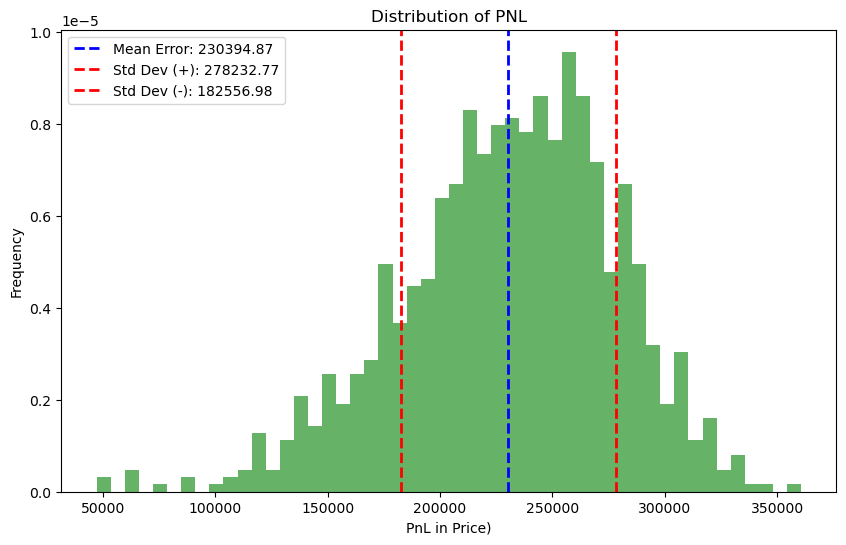

In [120]:
# 시뮬레이션 실행
results = simulate_and_calculate_hedging_cost_heston(S, X, r, q, kappa, theta, sigma, rho, T, nsim, interval, flag, shares_per_call)
mean_hedging_cost, performance_msr, mean_hedging_cost_tr, performance_msr_tr, _, _, _, mean_pnl, hedging_pnl, _ , _= results

theoretical_price = bsprice(S, X, r, q, T, imvol, flag)

# 5. Hedging Error 분석
std_error = np.std(hedging_pnl)  # PnL의 표준 편차
mean_error = np.mean(hedging_pnl)  # PnL의 평균

print(f"Mean PNL: {mean_error:.2f}")
print(f"Standard Deviation of PNL: {std_error:.2f}")

# 6. Relative Hedging Error 계산
option_premium = theoretical_price * shares_per_call  # 옵션 프리미엄
relative_std_error = (std_error / option_premium) * 100  # 상대 표준 편차

print(f"Performance meaure: {relative_std_error:.2f}%")

# PnL 가격 범위를 지정하여 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(hedging_pnl, bins=50, density=True, alpha=0.6, color='g', range=(np.min(hedging_pnl), np.max(hedging_pnl)))
plt.title('Distribution of PNL')
plt.xlabel('PnL in Price)')
plt.ylabel('Frequency')

# 평균과 표준 편차를 표시
plt.axvline(mean_error, color='blue', linestyle='dashed', linewidth=2, label=f'Mean Error: {mean_error:.2f}')
plt.axvline(mean_error + std_error, color='red', linestyle='dashed', linewidth=2, label=f'Std Dev (+): {mean_error + std_error:.2f}')
plt.axvline(mean_error - std_error, color='red', linestyle='dashed', linewidth=2, label=f'Std Dev (-): {mean_error - std_error:.2f}')
plt.legend()
plt.show()

### Heston vs. BSM

Heston 모델 헷징 결과:
Mean PnL: 232274.51
Standard Deviation of PnL: 48748.95
Performance Measure (Relative Hedging Error): 9.88%

GBM (40%) 헷징 결과:
Mean PnL: 151298.21
Standard Deviation of PnL: 67437.52
Performance Measure (Relative Hedging Error): 16.48%


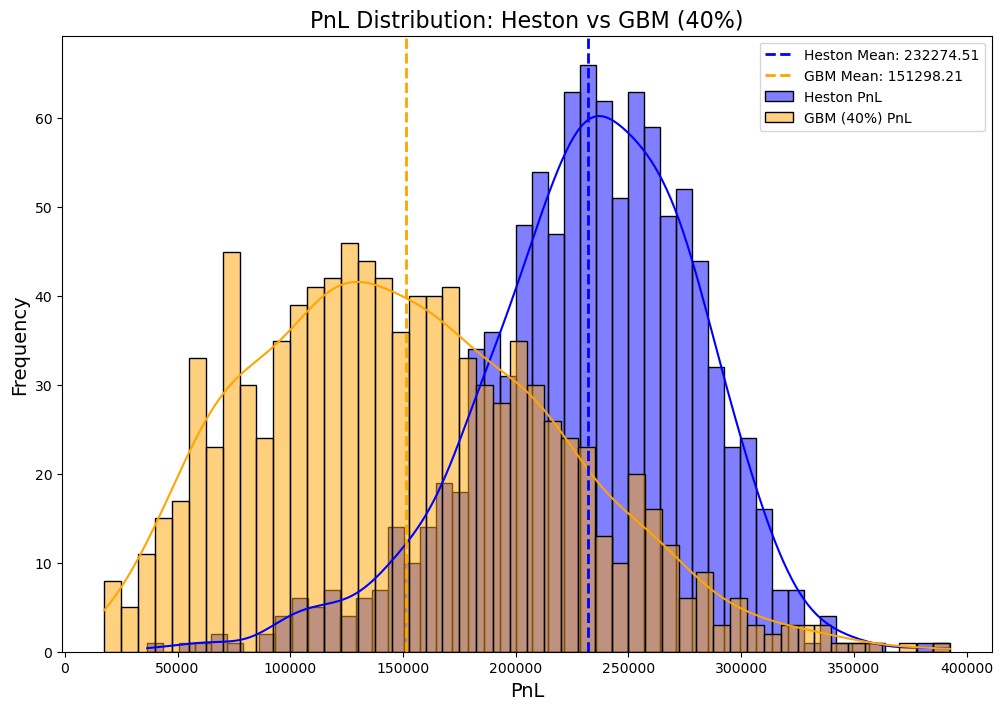

In [118]:
# GBM (40%) 헷징 성과 계산
gbm_results = simulate_and_calculate_hedging_cost_gbm(S, X, r, q, 0.4, T, nsim, interval, flag, shares_per_call, results[9])  # Heston 기반 주가 경로 사용

# 비교 결과 출력
print("Heston 모델 헷징 결과:")
print(f"Mean PnL: {mean_pnl:.2f}")
print(f"Standard Deviation of PnL: {std_error:.2f}")
print(f"Performance Measure (Relative Hedging Error): {relative_std_error:.2f}%")

print("\nGBM (40%) 헷징 결과:")
print(f"Mean PnL: {gbm_results['mean_pnl']:.2f}")
print(f"Standard Deviation of PnL: {gbm_results['std_pnl']:.2f}")
print(f"Performance Measure (Relative Hedging Error): {gbm_results['relative_error']:.2f}%")

# PnL 비교 히스토그램
plt.figure(figsize=(12, 8))
sns.histplot(hedging_pnl, bins=50, color='blue', alpha=0.5, label='Heston PnL', kde=True)
sns.histplot(gbm_results["hedging_pnl"], bins=50, color='orange', alpha=0.5, label='GBM (40%) PnL', kde=True)

plt.title("PnL Distribution: Heston vs GBM (40%)", size=16)
plt.xlabel("PnL", size=14)
plt.ylabel("Frequency", size=14)
plt.axvline(mean_pnl, color='blue', linestyle='dashed', linewidth=2, label=f'Heston Mean: {mean_pnl:.2f}')
plt.axvline(gbm_results['mean_pnl'], color='orange', linestyle='dashed', linewidth=2, label=f'GBM Mean: {gbm_results["mean_pnl"]:.2f}')
plt.legend()
plt.show()


결과분석:
1. Heston의 PNL이 훨씬 높아서 더 효율적으로 헷지했음을 알 수 있음
2. 헤지 퍼포먼스 또한 더 낮기에, 안정적이고 효과적인 헷지라는 것을 관측
3. 분포가 더 오른쪽으로 치우쳐져 있고, 분포가 더 좁고 날카로움 -> 헷징 성과가 안정적이고 예측가능함.

But, 내 마음대로 theta 파라미터를 정했음